In [772]:
import random
import pylab as plt
import torch
import numpy as np
import torch.nn as nn
import os
import copy

from tqdm.auto import tqdm
from sklearn import datasets

from dal_toolbox.models.deterministic.train import train_one_epoch as toe
from dal_toolbox.models.deterministic.evaluate import evaluate as eva

In [773]:
seed = 4
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [774]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 1):
    return X + torch.randn_like(X)*noise

In [775]:
class SSLDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets, noise):
        self.data = data
        self.targets = targets
        self.noise = noise

    def __getitem__(self, idx):
        X, y = self.data[idx], self.targets[idx]
        return [stochasitc_augmentation(X, self.noise), stochasitc_augmentation(X, self.noise)], y
    
    def __len__(self):
        return self.data.shape[0]

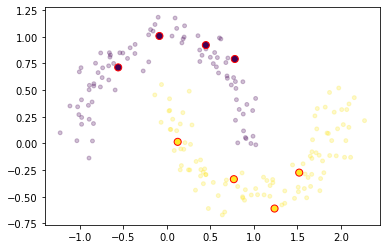

In [776]:
X, y = datasets.make_moons(300, noise=.1, random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

test_indices = random.sample(range(X.shape[0]), k = 100)
train_indices = [i for i in range(X.shape[0]) if i not in test_indices]
labeled_indices = random.sample(train_indices, k=8)
unlabeled_indices = [i for i in train_indices if i not in labeled_indices]
labeled_ds = torch.utils.data.TensorDataset(X[labeled_indices], y[labeled_indices])
unlabeled_ds = SSLDataset(X[train_indices], y[train_indices], noise=0.03)
test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])

plt.scatter(X[train_indices, 0], X[train_indices, 1], c=y[train_indices], s=15, alpha=.25)
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=50, edgecolors='red')
plt.show()

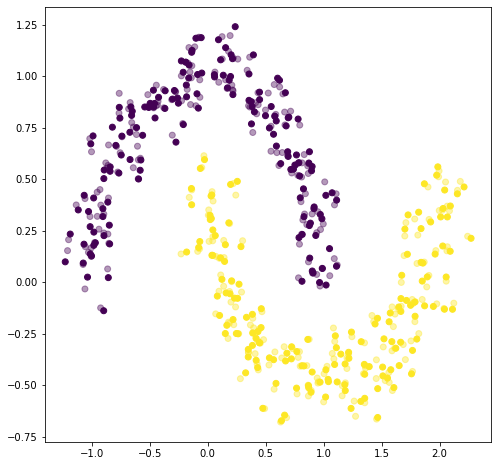

In [777]:
# What are useful values for noise?

X_trans = stochasitc_augmentation(X, 0.025)

fix = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_trans[:,0], X_trans[:,1], c=y, alpha=0.4)
plt.show()

In [778]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None, feature_extractor=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    if feature_extractor:
        feature_extractor.eval()
        feature_extractor.cpu()
        zz = feature_extractor(zz)
    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=15, alpha=.25)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [779]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 2, feature_dim: int = 128, projection_dim: int = 16):
        super(Net, self).__init__()
        self.base_encoder = nn.Sequential(nn.Linear(2, feature_dim), nn.ReLU(), nn.Linear(feature_dim, feature_dim), nn.ReLU())
        self.projector = nn.Sequential(nn.Linear(feature_dim, projection_dim), nn.ReLU())
        self.fc = nn.Linear(feature_dim, num_classes)


    def forward(self, x, get_projections=False):
        x = self.base_encoder(x)
        if get_projections:
            return self.projector(x)
        else:
            return self.fc(x)

In [780]:
LARGE_NUM = 1e9

class NTXent(nn.Module):
    def __init__(self, batch_size, u_ratio, hidden_norm: bool = True, temperature: int = 1.0, n_views: int = 2):
        super(NTXent, self).__init__()
        self.sim = nn.CosineSimilarity(dim=-1)
        self.temperature = temperature
        self.hidden_norm = hidden_norm
        self.device='cuda'
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.batch_size = batch_size * u_ratio
        self.n_views = n_views

    def forward(self, features):
        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = nn.functional.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        loss = self.ce_loss(logits, labels)

        return loss

In [781]:
def pretrain_one_epoch(model, optimizer, criterion, unsupervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples = 0, 0

    # Train the epoch
    for data, _ in unsupervised_loader:
        data = torch.cat(data, dim=0)
        data = data.to(device)
        batch_size = data.shape[0]

        # Unsupervised loss
        out = model(data, get_projections=True)
        loss = criterion(out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

        n_samples += batch_size * 2

    return {'loss':total_loss/n_samples}

In [782]:
def train_one_epoch(model, optimizer, criterion, supervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in supervised_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

        n_samples += batch_size

        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {'loss':total_loss/n_samples, 'acc':n_correct/n_samples}

In [783]:
def evaluate(model, criterion, test_loader, device='cuda'):
    model.eval()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item() * batch_size
        n_samples += batch_size
        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {
        'loss':total_loss/n_samples, 
        'acc':n_correct/n_samples
        }

In [784]:
## Pretrain a feature_extractor with an additional nonlinear feature transformation
n_epochs = 1000
n_iter_per_epoch = 10
batch_size = 32
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4
u_ratio = 1

n_classes = 2
feature_dim = 64
projection_dim = 16


model = Net(num_classes=n_classes, feature_dim=feature_dim, projection_dim=projection_dim)
model_state = copy.deepcopy(model.state_dict())
optimizer_fe = torch.optim.SGD(list(model.base_encoder.parameters()) + list(model.projector.parameters()), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler_fe = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fe, T_max=n_epochs)
unlabeled_sampler_fe = torch.utils.data.RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)
dataloader_fe = torch.utils.data.DataLoader(unlabeled_ds, batch_size=u_ratio * batch_size, sampler=unlabeled_sampler_fe)
criterion_fe = NTXent(batch_size=batch_size, u_ratio=u_ratio, temperature=1, hidden_norm=True)

history_fe = []

for i in tqdm(range(n_epochs)):
    train_stats = pretrain_one_epoch(model, optimizer_fe, criterion_fe, dataloader_fe)
    history_fe.append(
        {'train_stats':train_stats}
    )
    lr_scheduler_fe.step()
    if i > 200:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

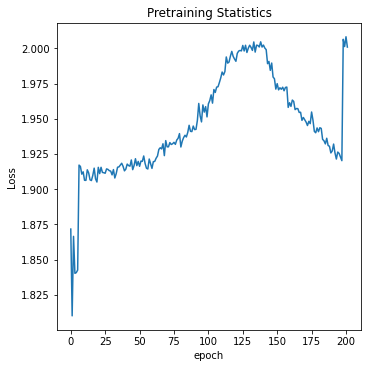

In [785]:
plt.figure(figsize=(5,5), constrained_layout=True)
plt.title("Pretraining Statistics")
plt.plot([h['train_stats']['loss'] for h in history_fe])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [786]:
## Train a classification layer using the extracted feature of the model above
n_epochs = 200
n_iter_per_epoch = 1
batch_size = 8
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4

optimizer_fc = torch.optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler_fc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fc, T_max=n_epochs)
labeled_sampler = torch.utils.data.RandomSampler(labeled_ds, generator=torch.Generator().manual_seed(42), num_samples=n_iter_per_epoch*batch_size)
dataloader_fc = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)
dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)
criterion_fc = nn.CrossEntropyLoss()

history_fc = []

for i in tqdm(range(n_epochs)):
    train_stats = train_one_epoch(model, optimizer_fc, criterion_fc, dataloader_fc)
    test_stats = evaluate(model, criterion_fc, dataloader_val)
    history_fc.append(
        {
        'train_stats': train_stats,
        'test_stats':test_stats
        }
    )
    lr_scheduler_fc.step()

  0%|          | 0/200 [00:00<?, ?it/s]

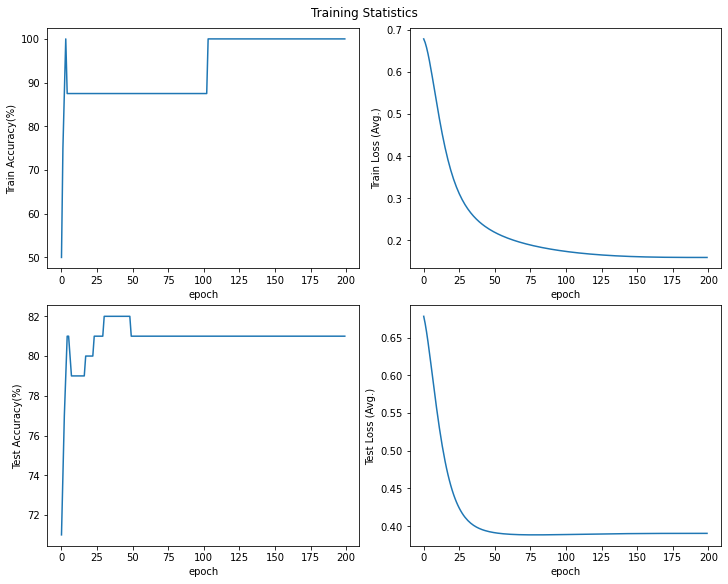

In [787]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['acc']*100 for h in history_fc])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history_fc])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc']*100 for h in history_fc])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history_fc])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

In [788]:
## Comparison to basic NN Fully supervised training
n_epochs = 100
n_iter_per_epoch = 1
batch_size = 8
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4

baseline = Net(num_classes=n_classes, feature_dim=feature_dim, projection_dim=projection_dim)
baseline.load_state_dict(model_state)
optimizer = torch.optim.SGD(baseline.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
labeled_sampler = torch.utils.data.RandomSampler(labeled_ds, generator=torch.Generator().manual_seed(42), num_samples=n_iter_per_epoch*batch_size)
dataloader = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)
dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)
criterion = nn.CrossEntropyLoss()

history = []

for i in tqdm(range(n_epochs)):
    train_stats = toe(baseline, dataloader, criterion, optimizer, device='cuda')
    test_stats = eva(baseline, dataloader_val, {}, criterion, device='cuda')
    history.append(
        {
        'train_stats': train_stats,
        'test_stats':test_stats
        }
    )
    lr_scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

  Train:  [0/1] eta: 0:00:00 lr: 0.1 loss: 0.6510 (0.6510) acc1: 75.0000 (75.0000) time: 0.0011 data: 0.0002 max mem: 26
  Train:  Total time: 0:00:00
  Train:  [0/1] eta: 0:00:00 lr: 0.09997532801828658 loss: 0.5864 (0.5864) acc1: 87.5000 (87.5000) time: 0.0009 data: 0.0001 max mem: 26
  Train:  Total time: 0:00:00
  Train:  [0/1] eta: 0:00:00 lr: 0.09990133642141358 loss: 0.5063 (0.5063) acc1: 100.0000 (100.0000) time: 0.0009 data: 0.0001 max mem: 26
  Train:  Total time: 0:00:00
  Train:  [0/1] eta: 0:00:00 lr: 0.099778098230154 loss: 0.4120 (0.4120) acc1: 100.0000 (100.0000) time: 0.0009 data: 0.0001 max mem: 26
  Train:  Total time: 0:00:00
  Train:  [0/1] eta: 0:00:00 lr: 0.0996057350657239 loss: 0.3145 (0.3145) acc1: 100.0000 (100.0000) time: 0.0009 data: 0.0001 max mem: 26
  Train:  Total time: 0:00:00
  Train:  [0/1] eta: 0:00:00 lr: 0.09938441702975688 loss: 0.2274 (0.2274) acc1: 100.0000 (100.0000) time: 0.0009 data: 0.0001 max mem: 26
  Train:  Total time: 0:00:00
  Train: 

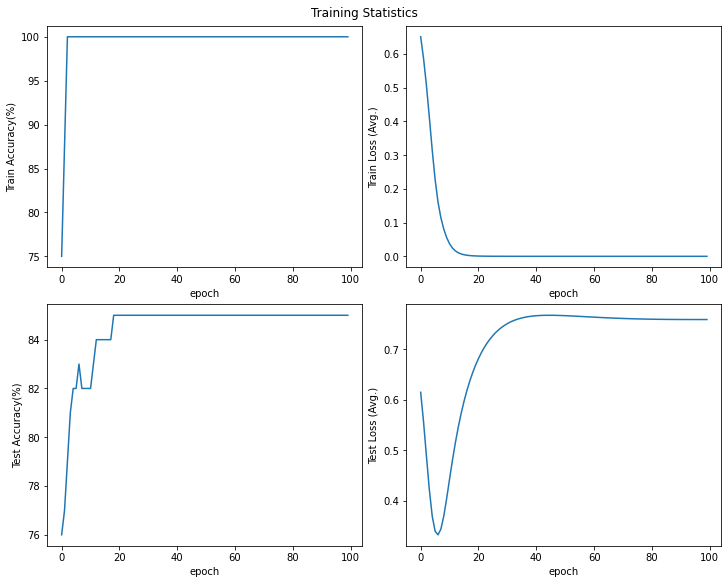

In [789]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['train_acc1'] for h in history])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['train_loss'] for h in history])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['test_acc1'] for h in history])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['test_loss'] for h in history])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

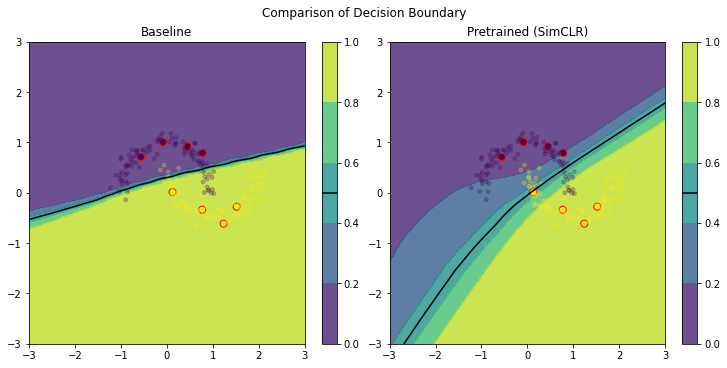

In [790]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Comparison of Decision Boundary")
plot_contour(baseline, X[labeled_indices], y[labeled_indices], X[unlabeled_indices], y[unlabeled_indices], ax[0])
ax[0].set_title("Baseline")
plot_contour(model, X[labeled_indices], y[labeled_indices], X[unlabeled_indices], y[unlabeled_indices], ax[1])
ax[1].set_title("Pretrained (SimCLR)")
plt.show()